In [47]:
import sys
import os
import string
import re
from tqdm import tqdm 

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, regexp_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt

from utils import dataset, generate_test_splits



### Using the included data importer

In [48]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
train_data = dataset.DataSet(name='train')

Reading dataset
Total stances: 49972
Total bodies: 1683


### Converting imported data into pandas dataframes

In [4]:
train_data_articles_df = pd.DataFrame({'Article': train_data.articles.values(), 'Body ID':train_data.articles.keys()} , index=train_data.articles.keys())
train_data_stances_df = pd.DataFrame(train_data.stances)

# checking out example output
print(train_data_articles_df['Article'][158] + '\n')
print(train_data_stances_df['Headline'][158] + '\n')
print(train_data_stances_df['Stance'][158])

Hundreds of Palestinians were evacuated from their homes Sunday morning after Israeli authorities opened a number of dams near the border, flooding the Gaza Valley in the wake of a recent severe winter storm.

The Gaza Ministry of Interior said in a statement that civil defense services and teams from the Ministry of Public Works had evacuated more than 80 families from both sides of the Gaza Valley (Wadi Gaza) after their homes flooded as water levels reached more than three meters.

Gaza has experienced flooding in recent days amid a major storm that saw temperatures drop and frigid rain pour down.

The storm displaced dozens and caused hardship for tens of thousands, including many of the approximately 110,000 Palestinians left homeless by Israel's assault over summer.

The suffering is compounded by the fact that Israel has maintained a complete siege over Gaza for the last eight years, severely limiting electricity and the availability of fuel for generators. It has also prevented

### Preprocessing: Tokenize and remove stopwords. 

Can do more, obvious ones: remove news agency header, remove website URL, remove twitter usernames, stemming, lemmatizating 

More done later during vectorization

In [5]:
tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b') # regex can be improved but idk
train_data_articles_df['article_cleaned'] = train_data_articles_df['Article'].apply(lambda x: tokenizer.tokenize(x.lower()))
train_data_stances_df['headline_cleaned'] = train_data_stances_df['Headline'].apply(lambda x: tokenizer.tokenize(x.lower()))

# remove_whitespace = r'\s+'
# train_data_articles_df['article_cleaned'] = train_data_articles_df['Article'].apply(lambda x: re.split(remove_whitespace, x))
# train_data_stances_df['headline_cleaned'] = train_data_stances_df['Headline'].apply(lambda x: re.split(remove_whitespace, x))

# exclude = r'[^/d/W]+'
# train_data_articles_df['article_cleaned'] = train_data_articles_df['article_cleaned'].apply(lambda x: re.findall(exclude, x))
# train_data_stances_df['headline_cleaned'] = train_data_stances_df['headline_cleaned'].apply(lambda x: re.findall(exclude, x))




In [6]:
print(train_data_articles_df['Article'][154])
print(train_data_articles_df['article_cleaned'][154])
print(train_data_stances_df['headline_cleaned'][154])
print(train_data_stances_df['Stance'][154])

Thousands of people have been duped by a fake news story claiming that Nasa has forecast a total blackout of earth for six days in December.

The story, entitled "Nasa Confirms Earth Will Experience 6 Days of Total Darkness in December 2014!" originated from Huzlers.com, a website well known for publishing fake stories with sensational headlines.

The bogus report read: "Nasa has confirmed that the Earth will experience 6 days of almost complete darkness and will happen from the dates Tuesday the 16 – Monday the 22 in December. The world will remain, during these three days, without sunlight due to a solar storm, which will cause dust and space debris to become plentiful and thus, block 90% sunlight.

"The head of Nasa Charles Bolden who made the announcement and asked everyone to remain calm. This will be the product of a solar storm, the largest in the last 250 years for a period of 216 hours total.

"Despite the six days of darkness soon to come, officials say that the earth will no

In [7]:
website_words = ['http', 'twitter', 'com', 'pic', 'co']
month_words = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'novemeber', 'december']
# TODO: think of more for these

my_banned_words = stopwords.words('english') + website_words + month_words


In [8]:
def remove_stopwords(string):
    output = []
    for word in string:
        if word not in my_banned_words:
            output.append(word)
    return output

train_data_articles_df['article_cleaned'] =  train_data_articles_df['article_cleaned'].apply(lambda x: remove_stopwords(x))
train_data_stances_df['headline_cleaned'] =  train_data_stances_df['headline_cleaned'].apply(lambda x: remove_stopwords(x))


In [56]:
# lemmatization
print(train_data_stances_df['headline_cleaned'][24])
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(string):
    output = []
    for word in string:
        output.append(lemmatizer.lemmatize(word))
    return output
    
train_data_articles_df['article_cleaned'] =  train_data_articles_df['article_cleaned'].apply(lambda x: lemmatize_tokens(x))
train_data_stances_df['headline_cleaned'] =  train_data_stances_df['headline_cleaned'].apply(lambda x: lemmatize_tokens(x))

print(train_data_stances_df['headline_cleaned'][24])


['net', 'extra', 'back', 'dead', 'catholic', 'priest', 'claims', 'god', 'female']
['net', 'extra', 'back', 'dead', 'catholic', 'priest', 'claim', 'god', 'female']


In [57]:
print(train_data_articles_df['article_cleaned'][154])


['thousand', 'people', 'duped', 'fake', 'news', 'story', 'claiming', 'nasa', 'forecast', 'total', 'blackout', 'earth', 'six', 'day', 'story', 'entitled', 'nasa', 'confirms', 'earth', 'experience', 'day', 'total', 'darkness', 'originated', 'huzlers', 'website', 'well', 'known', 'publishing', 'fake', 'story', 'sensational', 'headline', 'bogus', 'report', 'read', 'nasa', 'confirmed', 'earth', 'experience', 'day', 'almost', 'complete', 'darkness', 'happen', 'date', 'tuesday', 'monday', 'world', 'remain', 'three', 'day', 'without', 'sunlight', 'due', 'solar', 'storm', 'cause', 'dust', 'space', 'debris', 'become', 'plentiful', 'thus', 'block', 'sunlight', 'head', 'nasa', 'charles', 'bolden', 'made', 'announcement', 'asked', 'everyone', 'remain', 'calm', 'product', 'solar', 'storm', 'largest', 'last', 'year', 'period', 'hour', 'total', 'despite', 'six', 'day', 'darkness', 'soon', 'come', 'official', 'say', 'earth', 'experience', 'major', 'problem', 'since', 'six', 'day', 'darkness', 'nowhere'

In [58]:
if not os.path.exists('processed'):
    os.mkdir('processed')

train_data_articles_df.to_csv("processed/processed_train_articles.csv")
train_data_stances_df.to_csv("processed/processed_train_stances.csv")


 ### Strategy: concatenate headline with article, encode as tfidf score
 
TODO: more to try: only tf, tf of headline and article + tfidf cosine similarity (ranked 3rd group's strat), process headline and article separately (can then run an algorithm separately on each part, then concat and run fully connected) (need to generate dictionary for this one) 

In [12]:
stance_to_number = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2,
    "unrelated": 3
}

        
def concat_data(articles_df, headlines_df, body_ids):
    features = []
    labels = []
    
    for body_id in body_ids:
        article = articles_df[articles_df['Body ID'] == body_id]['article_cleaned'].values[0]
    #     print(article)
        headlines = headlines_df[headlines_df['Body ID'] == body_id]['headline_cleaned'].values
    #     print(headlines)
        stances = headlines_df[headlines_df['Body ID'] == body_id]['Stance'].values
    #     print(stances)
        for headline, stance in zip(headlines, stances):
            features.append(headline+article)
#             label_idx = stance_to_number[stance]
#             label = [0.0, 0.0, 0.0, 0.0] # one hot encoding for labels
#             label[label_idx] = 1.0
#             labels.append(label)
            labels.append(stance_to_number[stance])
    return features, labels

body_ids = train_data_articles_df['Body ID'].copy().values
print(body_ids[0:10])
np.random.seed(42) # set your seed
np.random.shuffle(body_ids) # randomise it here and then do the train/val split later directly. If randomised later then validation and training set each will draw from their own datasets
print(body_ids[0:10])
features, labels = concat_data(train_data_articles_df, train_data_stances_df, body_ids) # article, headline and stances are retrieved at the same time so splitting later is fine


[ 0  4  5  6  7  8  9 10 11 13]
[2102 1120 2414   75  298  720 1340  931 2448 2032]


In [59]:
print(features[0])
print(labels[0])

['unconfirmed', 'reports', 'saying', 'isis', 'uk', 'hostage', 'david', 'haines', 'beheaded', 'uk', 'confirmed', 'video', 'showing', 'beheading', 'aid', 'worker', 'david', 'haines']
2


In [60]:
# dummy preprocessor and tokenizer because already did that above. not going to change it up to fit this format
num_features = 5000

def dummy(doc):
    return doc
vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, max_features=num_features) # try messing with min_df param: can remove twitter handles and such
features_counts = vectorizer.fit_transform(features)


print(features_counts.shape)

(49972, 5000)


In [61]:
# more preprocessing: dropping very common non-stopword words and very uncommon words
# features_counts_flip = np.flip(features_counts)
# features_counts_df = pd.DataFrame(features_counts_flip, columns=vectorizer.get_feature_names_out())
# print(features_counts_df.head)

print(vectorizer.get_feature_names_out()[0:50])
print(np.where(vectorizer.get_feature_names_out() == "hijanellamarie"))

['aamir' 'aaron' 'abandoned' 'abandoning' 'abc' 'abdel' 'abdi' 'abdomen'
 'abducted' 'abducting' 'abduction' 'abductions' 'abdul' 'abdulla'
 'abdullah' 'ability' 'able' 'abortion' 'abrams' 'abroad' 'absence'
 'absent' 'absenteeism' 'absolutely' 'abu' 'abubakar' 'abuja' 'abuse'
 'abuses' 'academy' 'accent' 'accept' 'accepted' 'access' 'accessories'
 'accident' 'accidental' 'accidentally' 'accompanied' 'according'
 'account' 'accounts' 'accurate' 'accusations' 'accused' 'achieve'
 'acknowledged' 'acquisition' 'acre' 'across']
(array([], dtype=int64),)


In [62]:
# NOW do the train val split. 
# Vectorise and get bag of words for both train + test first so that the features are the same length
# can also instead generate a dictionary beforehand to pass into the vectorizer

train_percentage = 0.8
num_samples = features_counts.shape[0]
split_index = int(train_percentage*num_samples)
train_features_counts = features_counts[:split_index]
val_features_counts = features_counts[split_index:]
train_labels = labels[:split_index]
val_labels = labels[split_index:]

In [63]:
tfidf_transformer = TfidfTransformer()
train_features_tfidf = tfidf_transformer.fit_transform(train_features_counts)
val_features_tfidf = tfidf_transformer.fit_transform(val_features_counts)

print(train_features_tfidf.shape)

(39977, 5000)


In [64]:
# saving the vectors
# train_features_tfidf_nparray = train_features_tfidf.toarray()
# test_features_tfidf_nparray = test_features_tfidf.toarray()

# np.savetxt("processed/vector_train_features_tdidf.txt", train_features_tfidf_nparray)
# np.savetxt("processed/vector_test_features_tdidf.txt", test_features_tfidf_nparray)
# >22GB

# the file size is so big for the vectorized array 
# i think it's better to save the data as just list of sentences and load them, 
# then do the vectorization


In [65]:
print(train_features_tfidf[0].toarray().shape)

(1, 5000)


In [66]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=2500) # TODO: mess with the hidden layer sizes
        self.fc2 = nn.Linear(in_features=2500, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=out_dim)
        
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        
        x = self.fc2(x)
        x = nn.functional.relu(x)
        
        x = self.fc3(x)
        x = nn.functional.relu(x)
        
        x = self.fc4(x)
        
        return x
    

In [67]:
input_dimensions = num_features
out_dimensions = 4

model = MultiLayerPerceptron(input_dimensions, out_dimensions)

In [68]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
criterion = criterion.to(device)

cuda


In [70]:
# for batches 
batch_size = 32

train_features_tfidf_array = train_features_tfidf.toarray()
val_features_tfidf_array = val_features_tfidf.toarray()

train_iterator = data.DataLoader([[train_features_tfidf_array[i], train_labels[i]] for i in range(len(train_labels))],
                                 shuffle=True,
                                 batch_size=batch_size,
                                 num_workers=2)

val_iterator = data.DataLoader([[val_features_tfidf_array[i], val_labels[i]] for i in range(len(val_labels))],
                                 shuffle=True,
                                 batch_size=batch_size,
                                 num_workers=2)

train_iterator_size = len(train_iterator)
val_iterator_size = len(val_iterator)
print(train_iterator_size)

1250


In [71]:
def calculate_accuracy(y, label):
#     y.view(1, 4)
#     label.view(1,)
#     print(y)
#     print(label)
    top_pred = y.argmax(1, keepdim=True)
    correct = top_pred.eq(label.view_as(top_pred)).sum()
    acc = correct.float() / label.shape[0]
    return acc

In [72]:
epochs = 5
overall_train_loss = []
overall_val_loss = []
overall_train_acc = []
overall_val_acc = []

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for x, label in tqdm(train_iterator, desc=f"Epoch {epoch+1} training", leave=False):
#     for idx in tqdm(range(train_features_tfidf.shape[0]), desc=f"Epoch {epoch+1} training"):
#         x = train_features_tensor[idx].float()
#         label = train_labels_tensor[idx].long()
        
        x = x.to(device)
        label = label.to(device)
        
        x = x.float() 
        label = label.long()
        
        optimizer.zero_grad()
        y = model(x)

        loss = criterion(y, label)
        acc = calculate_accuracy(y, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += acc.item()
        
    train_loss /= train_iterator_size
    train_acc /= train_iterator_size
    
    overall_train_loss.append(train_loss)
    overall_train_acc.append(train_acc)
    
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for x, label in tqdm(val_iterator, desc=f"Epoch {epoch+1} validating", leave=False):
#         for idx in tqdm(range(val_features_tfidf.shape[0]), desc=f"Epoch {epoch+1} validating"):
#             x = val_features_tensor[idx].float()
#             label = val_labels_tensor[idx].long()
            x = x.to(device)
            label = label.to(device)
            
            x = x.float() 
            label = label.long()

            y = model(x)

            loss = criterion(y, label)
            acc = calculate_accuracy(y, label)

            val_loss += loss.item()
            val_acc += acc.item()
            
    val_loss /= val_iterator_size
    val_acc /= val_iterator_size
    
    overall_val_loss.append(val_loss)
    overall_val_acc.append(val_acc)
    
    print(f"epoch {epoch+1}:")
    print(f"train loss = {train_loss:.3f}; train acc = {train_acc*100:.3f}%")
    print(f"val loss = {val_loss:.3f}; val acc = {val_acc*100:.3f}%")

epoch 1:
train loss = 0.587; train acc = 78.048%
val loss = 0.856; val acc = 64.341%


epoch 2:
train loss = 0.430; train acc = 83.922%
val loss = 0.906; val acc = 65.250%


epoch 3:
train loss = 0.331; train acc = 87.464%
val loss = 0.914; val acc = 69.033%


epoch 4:
train loss = 0.257; train acc = 89.943%
val loss = 1.073; val acc = 66.218%


epoch 5:
train loss = 0.213; train acc = 91.492%
val loss = 0.904; val acc = 70.678%


In [73]:
def plot_loss_acc (train_loss, val_loss, train_acc, val_acc):
  fig, ax = plt.subplots(1,2)
  
  ax[0].set_title("Loss")
  ax[0].plot(train_loss, label="Training")
  ax[0].plot(val_loss, label="Validation")
  ax[0].legend()


  
  ax[1].set_title("Accuracy")
  ax[1].plot(train_acc, label="Training")
  ax[1].plot(val_acc, label="Validation")
  ax[1].legend()



  return

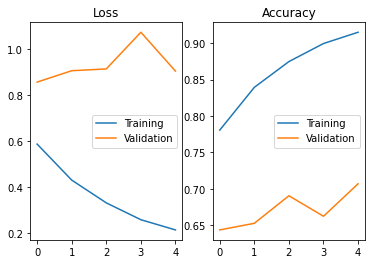

In [74]:
plot_loss_acc(overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc)